# Capstone - The Battle of the Neighborhoods - Chicago

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction: Business Problem

Setting the Stage: The owner of an Mexican restaurant chain is planning on expanding in Chicago. He is aware that there are already a high number of Mexican restaurants throughout the city, so he wants to ensure that the location(s) he chooses to expand to are not over saturated. The ideal neighborhood would only have a few competitors, but a large enough population to ensure they would have a consistent customer base. 

---
In order to solve this scenario, I will be bringing in data from a handful of sources in order to analyze the 77 neighborhoods in Chicago. We will be able to use a combination of all of these data sources to allow us to see what neighborhoods will be the best places of opportunity for the restaurant chain to expand. 

### Data

In order to compare the community areas in Chicago based on their populations, geographical locations, and volume/types of venues I will utilize 3 data sources. 

In this notebook we will import data from three sources:

1.Wikipedia - We will be utilizing a wikipedia table which lists all 77 neighborhoods in Chicago, along with some demographic data from 2018

2.Geolocator - We will use geolocator to provide longitude and latitude data for the neighborhoods

3.Finally, we will be using FourSquare to get data on the venues in each of these neighborhoods.


#### Before we get started with importing and analyzing the data, we must import all necessary libraries.

We are including specific libraries to help in our geographical analyis (geopy), libraries to allow us to perform clustering analysis (sklearn), and libraries to assist with webscraping (beautiful soup)

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#beautifulsoup
!pip install beautifulsoup4
from bs4 import BeautifulSoup

print('Libraries imported.')


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Libraries imported.


#### The first piece of data we will import is a wikipedia table which holds a list of Chicago's 77 neighborhoods, populations as of 2018, as well as geographical data.

##### Before we can extract, we must validate that we can scrape data. A response of 200 means that we can.

In [2]:
url ='https://en.wikipedia.org/wiki/Community_areas_in_Chicago'
response=requests.get(url)
print(response.status_code)

200


##### Now we will parse data from the html into a beautifulsoup object, then review the code to determine what the class is for the table we want to extract. When we have this, we can extract the table into it's own object titled 'fulltable'.

In [3]:
soup = BeautifulSoup(response.text, 'html.parser')
#print(soup.prettify())
tables = soup.find_all('table')
#print(tables)

fulltable = soup.find('table', {"class":"wikitable sortable plainrowheaders mw-datatable"})

##### In order to be able to use this data for our purpose, we will add it to a dataframe and evaluate it's shape and fields. 

In [4]:
fulltable=pd.read_html(str(fulltable))
fulltable=pd.DataFrame(fulltable[0])

#check shape of df and validate 
print(fulltable.shape)
print(fulltable.head())

#define the columns
fulltable.columns = ['No.', 'Neighborhood', 'Population','Area_SQM', 'Area_KM2', 'Density_SQM', 'Density_KM2']
                     
fulltable.head()

(78, 7)
                 No.               Name Population  Area[9]         Density  \
  Unnamed: 0_level_1 Unnamed: 1_level_1 (2018)[10] (sq mi.) (km2) (/sq mi.)   
0                 01        Rogers Park      54872     1.84  4.77  29821.74   
1                 02         West Ridge      77212     3.53  9.14  21873.09   
2                 03             Uptown      58424     2.32  6.01  25182.76   
3                 04     Lincoln Square      41713     2.56  6.63  16294.14   
4                 05       North Center      35705     2.05  5.31  17417.07   

             
     (/km2)  
0  11514.24  
1   8445.25  
2   9723.12  
3   6291.20  
4   6724.77  


,No.,Neighborhood,Population,Area_SQM,Area_KM2,Density_SQM,Density_KM2
0,01,Rogers Park,54872,1.84,4.77,29821.74,11514.24
1,02,West Ridge,77212,3.53,9.14,21873.09,8445.25
2,03,Uptown,58424,2.32,6.01,25182.76,9723.12
3,04,Lincoln Square,41713,2.56,6.63,16294.14,6291.20
4,05,North Center,35705,2.05,5.31,17417.07,6724.77


##### Now that the data is in a dataframe, we can easily perform the processing that we need to - dropping columns that we don't need and ensuring that the data is high quality

In [5]:
#Pre-Processing 

#Dropping columns we don't need
CHIdf = fulltable.drop(['No.', 'Area_KM2','Density_KM2'], axis=1)
CHIdf.head()

# Check for missing values

#I will check to see if there are any missing zip code values
CHIdf["Neighborhood"].isnull()

#I will now check if there any duplicate neighborhoods
# Selecting duplicate rows except first 
duplicate = CHIdf[CHIdf.duplicated('Neighborhood')]
  
print("Duplicate Rows :")
print(duplicate)

Duplicate Rows :
Empty DataFrame
Columns: [Neighborhood, Population, Area_SQM, Density_SQM]
Index: []


### For our next step in the data process - we will be using geolocator to bring in our longitude and latitude data for each neighborhood. 


#### Once we have the coordinates, we will perform the same cleansing and reorganizing actions we did with the neighborhood table. 

In [6]:
location = [x for x in CHIdf['Neighborhood'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    try:
        address = location[i] + ', Chicago, IL'
        geolocator = Nominatim(user_agent="IL_explorer")
        loc = geolocator.geocode(address)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the location, latitude and longitude
df_ = pd.DataFrame({'Neighborhood':location, 
                    'Location_Latitude': latitude,
                    'Location_Longitude':longitude})
# merge on CHIdf with df_ to get the column 
new_df = CHIdf.merge(df_, on='Neighborhood', how='left')
print(new_df.shape)

(78, 6)


In [7]:
new_df.head()

,Neighborhood,Population,Area_SQM,Density_SQM,Location_Latitude,Location_Longitude
0,Rogers Park,54872,1.84,29821.74,42.009037,-87.676849
1,West Ridge,77212,3.53,21873.09,42.003548,-87.696243
2,Uptown,58424,2.32,25182.76,41.966630,-87.655546
3,Lincoln Square,41713,2.56,16294.14,41.968512,-87.688653
4,North Center,35705,2.05,17417.07,41.956107,-87.679160


In [8]:
#Define the new columns
new_df.columns = ['Neighborhood', 'Population', 'Area_SQM', 'Density_SQM', 'Latitude', 'Longitude']

# Let's first take a look at our final dataframe 
print(new_df)

#Check for missing data in the new columns

new_df['Latitude'].isnull()
new_df['Longitude'].isnull()

new_df.dtypes

              Neighborhood  Population  Area_SQM  Density_SQM   Latitude  \
0              Rogers Park       54872      1.84     29821.74  42.009037   
1               West Ridge       77212      3.53     21873.09  42.003548   
2                   Uptown       58424      2.32     25182.76  41.966630   
3           Lincoln Square       41713      2.56     16294.14  41.968512   
4             North Center       35705      2.05     17417.07  41.956107   
5                Lake View      100547      3.12     32226.60  41.943919   
6             Lincoln Park       68697      3.16     21739.56  41.940313   
7          Near North Side       89995      2.74     32844.89  41.900033   
8              Edison Park       11567      1.13     10236.28  42.004353   
9             Norwood Park       37312      4.37      8538.22  41.988066   
10          Jefferson Park       27989      2.33     12012.45  41.969738   
11             Forest Glen       19113      3.20      5972.81  41.985493   
12          

Neighborhood     object
Population        int64
Area_SQM        float64
Density_SQM     float64
Latitude        float64
Longitude       float64
dtype: object

In [9]:
#Get coordinates for these neighborhoods
address = 'Chicago, IL'
geolocator = Nominatim(user_agent="IL_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


### We are at a point where we have all of the geographical data that we need on Chicago. In order to better understand what we are looking at, it is a good idea to put all of the neighborhoods on a map of the city. 

#### We will use folium to create this map, and add markers for each of the neighborhoods.

In [10]:
# create map of Chicago using latitude and longitude values
chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(new_df['Latitude'], new_df['Longitude'], new_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chicago)  
    
chicago

## Now that we have all of the information that we need from the neighborhoods, we can move along and start to analyze the venues in these areas. 

#### Add in Foursquare API Details

In [11]:
CLIENT_ID = 'OM5K3K34RJCKCX0ALN4WDUAKTWL1UQIZVMXTZZ52454TA1P4' # your Foursquare ID
CLIENT_SECRET = 'OAYTNTT1WHYVATPBMHMBURKJTSZQQ25XKH0JVN4WK0WRVVYC' # your Foursquare Secret
ACCESS_TOKEN = 'GAEJE4S125BDKW0QICJE5NPMS2IR4I54BF0T3BJPOIURYBM4'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OM5K3K34RJCKCX0ALN4WDUAKTWL1UQIZVMXTZZ52454TA1P4
CLIENT_SECRET:OAYTNTT1WHYVATPBMHMBURKJTSZQQ25XKH0JVN4WK0WRVVYC


In [12]:
#Get the information for the first zipcode in our list
new_df.loc[0, 'Neighborhood']

#get data on this neighborhood using index 0
neighborhood_latitude = new_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = new_df.loc[0, 'Longitude'] #neighborhood longitude value
neighborhood = new_df.loc[0, 'Neighborhood'] #Neighborhood

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Rogers Park are 42.0090367, -87.6768492.


### We will now explore the top 100 venues which are within 800M of Rogers Park, then put those into a dataframe. 

In [13]:
#Explore top 100 venues within 500 M of Rogers Park --> create API URL
radius = 800
LIMIT = 100

url ='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

#get results to view
results = requests.get(url).json()
results

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#put values into pd dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.head())

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

                                name          categories        lat        lng
0                         Bark Place           Pet Store  42.010080 -87.675223
1                  El Famous Burrito  Mexican Restaurant  42.010421 -87.674204
2  Taqueria & Restaurant Cd. Hidalgo  Mexican Restaurant  42.011634 -87.674484
3                Mind Crusher Tattoo       Tattoo Parlor  42.003801 -87.672525
4                             Subway      Sandwich Place  42.009335 -87.677994
45 venues were returned by Foursquare.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


#### We can see that within 800M of Rogers park there are 19 different venues in the area, including a range of categories.

Now that we have an idea of what kind of data we can get from FourSquare, we can apply the method to the rest of the neighborhoods in Chicago. 

We will do this by creating a new function, titled "getNearbyVenues".

In [14]:
# Create function to get info on all the venues in chicago
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now that the function getNearbyVenues is defined, we can apply it to our neighborhoods and create a dataframe

In [15]:
#Run the above on all venues and create new DF
chicago_venues = getNearbyVenues(names = new_df['Neighborhood'],
                                 latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

chicago_venues.head()

#check # of venues per neighborhood
chicago_venues.groupby('Neighborhood').count()

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
(The) Loop[11]
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater
Chicago[12]


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
(The) Loop[11],100,100,100,100,100,100
Albany Park,52,52,52,52,52,52
Archer Heights,41,41,41,41,41,41
Armour Square,30,30,30,30,30,30
Ashburn,19,19,19,19,19,19
Auburn Gresham,12,12,12,12,12,12
Austin,5,5,5,5,5,5
Avalon Park,11,11,11,11,11,11
Avondale,70,70,70,70,70,70


### From this dataframe, we can see that a different number of venues are located in each of the neighborhoods. 

In order to ensure all of our data is clean, we will now preprocess it.This will include running onehot encoding to get dummies for any missing venues - so that we don't have missing data

In [16]:
#check for missing data
chicago_venues.isnull()

# creating bool series True for NaN values 
bool_series = pd.isnull(chicago_venues["Neighborhood"]) 
    
# filtering data 
# displaying data only with zip = NaN 
chicago_venues[bool_series] 

#Get all data for each specific neighborhood

# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood']

# define a list of column names
cols = chicago_onehot.columns.tolist()
cols

# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols

#then use .reindex() function to reorder
chicago_onehot = chicago_onehot.reindex(columns= cols)

#check result
chicago_onehot.head()

,Neighborhood,ATM,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Check Cashing Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Quad,College Rec Center,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Radio Station,Ramen Restaurant,Real Estate Office,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,S

# Methodology 

For this project, we will focusing our work on detecting which neighborhoods in Chicago have a low density of restaurants, partically of Mexican cuisine. 

Our first priority was to gather geographic and demographic information on the neighborhoods, including: neighborhood names, populations, and coordinates. Once we had this data, we were able to utilize the FourSquare API to gather all relevant information on restaurants within 800M of the neighborhoods. We opted to use a range of 800M, as Chicago is very spread out geographically. 
    
Next, the data analysis took place. This included investigation on the types of venues in each neighborhood, as well as how frequent each type is. Once we had this step completed, we were able to move forward with our statistical analysis. In order to keep things relatively straightforward, we opted to use k-means clustering as our clustering tool. This is a relatively popular way to cluster data in the data science industry, and is well respected. 

Our final step was to evaluate our resulting clusters - we did so by visually assessing where the clusters were geographically and by examining the cluster details. As a reminder, our focus was to evaluate what neighborhoods would be the best fit for expanding a sit-down Mexican chain restaurant. 


# Analysis

### Next, we will group rows by neighborhood and take the mean of the frequency of the occurence of each category 


In [37]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped

,Neighborhood,ATM,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Check Cashing Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Quad,College Rec Center,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Radio Station,Ramen Restaurant,Real Estate Office,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,S

### Let's pull the top 5 most frequent venue types from each neighborhood.

#### This will give us a more complete picture of what types of venues are in each neighborhood, regardless of their size or density. 

In [18]:
num_top_venues = 5

for hood in chicago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----(The) Loop[11]----
         venue  freq
0        Hotel  0.08
1      Theater  0.05
2  Coffee Shop  0.05
3  Salad Place  0.04
4        Plaza  0.03


----Albany Park----
                venue  freq
0  Mexican Restaurant  0.08
1       Grocery Store  0.06
2                Park  0.06
3          Donut Shop  0.04
4   Korean Restaurant  0.04


----Archer Heights----
                venue  freq
0  Mexican Restaurant  0.12
1   Mobile Phone Shop  0.07
2                Food  0.05
3  Seafood Restaurant  0.05
4       Grocery Store  0.05


----Armour Square----
                     venue  freq
0       Chinese Restaurant  0.13
1                      Bar  0.07
2        Currency Exchange  0.03
3  New American Restaurant  0.03
4       Mexican Restaurant  0.03


----Ashburn----
            venue  freq
0            Park  0.16
1     Pizza Place  0.11
2   Train Station  0.11
3    Liquor Store  0.11
4  Cosmetics Shop  0.05


----Auburn Gresham----
                     venue  freq
0                 Boutique

In [38]:
#put the above data in a dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_venues_sorted = pd.DataFrame(columns=columns)
zip_venues_sorted['Neighborhood'] = chicago_grouped["Neighborhood"]

for ind in np.arange(chicago_grouped.shape[0]):
    zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

zip_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,(The) Loop[11],Hotel,Coffee Shop,Theater,Salad Place,Mediterranean Restaurant,Plaza,Sandwich Place,Museum,Snack Place,Seafood Restaurant
1,Albany Park,Mexican Restaurant,Park,Grocery Store,Donut Shop,Middle Eastern Restaurant,Chinese Restaurant,Korean Restaurant,Sandwich Place,Hookah Bar,Pizza Place
2,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Food,Grocery Store,Donut Shop,Fast Food Restaurant,Bakery,Bank,Bar
3,Armour Square,Chinese Restaurant,Bar,Currency Exchange,Grocery Store,Tailor Shop,Storage Facility,Gas Station,New American Restaurant,Bakery,Sandwich Place
4,Ashburn,Park,Train Station,Pizza Place,Liquor Store,Cosmetics Shop,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Bus Station,Locksmith


# Our data importation is now complete - we have all of the information we need in order to perform our statisical analysis. 

### To move forward, we will use k-means cluster analysis which is very popular in data science. In order to run this analysis, we must first discover what our optimal K is, which signifies the number of clusters to be created in the model.

#### We will find the optimal k by running a series of k means on the clusters, then reviewing using the elbow method. The elbow method is also very popular in data analysis, but does leave a smidge of digression up to the data scientist. Another method you could opt to use is the silhouette method. 

In [40]:
chicago_clusters = chicago_grouped.drop('Neighborhood', axis=1)

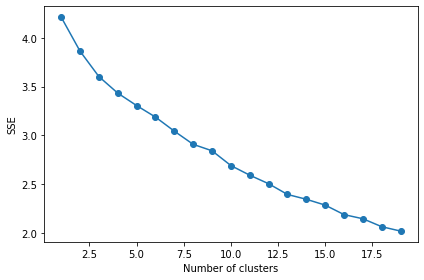

In [22]:
import matplotlib.pyplot as plt 

X = chicago_clusters

sse = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    sse.append(km.inertia_)
    
# plot the distortion for number of clusters   
plt.plot(range(1, 20), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.tight_layout()


plt.show()

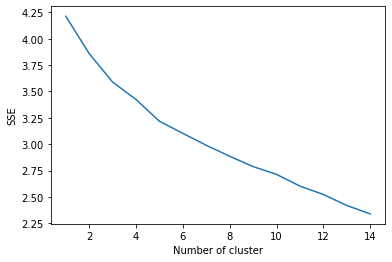

In [23]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(chicago_clusters)
    chicago_clusters["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

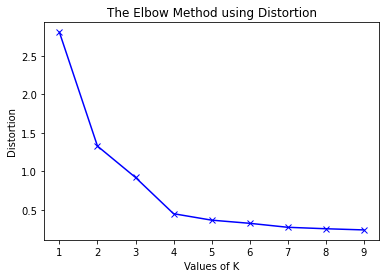

In [24]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = chicago_clusters
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### From these graphs - the elbow seems to rest somewhere between 2 and 3 clusters. I am going to use 3 clusters, as it will provide us with the ability to provide a more accurate response for our business problem.

##### Now that we have our K value of 3, we can perform the k-means cluster analysis. We will set the number of clusters to 3, the random state to 0 - and set it to fit our cluster dataframe. 

In [41]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 1, 0, 3, 1, 0, 2], dtype=int32)

### We will use the analysis performed and add all of the cluster labels to a dataframe - then merge it with the grouped data

In [42]:
#Add cluster labels to df

# add clustering labels
zip_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = new_df

# merge chicago_grouped with new_df to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(zip_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chicago_merged.head(5) # check the last columns!

chicago_merged.dtypes


Neighborhood               object
Population                  int64
Area_SQM                  float64
Density_SQM               float64
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

### Now for some more pre-processing and cleaning before we perform our final analysis. 

#### - We will check for missing values, from assessing we can see there is one neighborhood missing a cluster value, Riverdale. This is due to a limited number of venues in the area. We will default that to 0, our largest cluster. 

#### - From the above you can see that the "Cluster Label" is a float datatype, in order to create a map of the clusters we will need this to be an int value. So we must update the type utilizing astype. 

In [43]:
#Evaluate for any missing values, fill with 0 (the only missing value is a cluster for 1 neighborhood)

chicago_merged.isnull()

chicago_merged = chicago_merged.fillna(0)

# creating a dictionary 
# with column name and data type
data_types_dict = {'Cluster Labels': int}
  
# we will change the data type 
# of id column to str by giving
# the dict to the astype method
chicago_merged = chicago_merged.astype(data_types_dict)
  
# checking the data types
# using df.dtypes method
chicago_merged.dtypes


Neighborhood               object
Population                  int64
Area_SQM                  float64
Density_SQM               float64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

# Results and Discussion 

Now, we will visualize the clusters that we have created on a map of Chicago

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### The map above shows us a few things based on the cluster placement: 
- All 4 clusters have neighborhoods in the North, West, and South sides of Chicago. This shows us that the clustering is not solely based on geographic location.
- Cluster 0 (red) is our largest cluster, and covers the whole city. However, it is the most prominent cluster in the city center ("The Loop") and north side. 
- Cluster 1 (purple) is contains mostly southside neighborhoods
- Cluster 2 (aqua) is made up of neighborhoods on the West side of the city, outside of city center
- Cluster 3 (green) is our smallest cluster, and is distributed randomly throughout the city. 

## Lastly, we will examine the details for each of the 4 clusters: 

In [45]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(1, chicago_merged.shape[1]))]]

,Neighborhood,Population,Area_SQM,Density_SQM,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Ridge,77212,3.53,21873.09,42.003548,-87.696243,0,Indian Restaurant,Grocery Store,Park,Convenience Store,Bakery,Liquor Store,Fruit & Vegetable Store,Fried Chicken Joint,Mediterranean Restaurant,Football Stadium
2,Uptown,58424,2.32,25182.76,41.966630,-87.655546,0,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Pizza Place,Diner,Mexican Restaurant,Sushi Restaurant,Thai Restaurant,Sandwich Place,Discount Store
3,Lincoln Square,41713,2.56,16294.14,41.968512,-87.688653,0,Bar,Thai Restaurant,Mobile Phone Shop,Pizza Place,Sandwich Place,Sushi Restaurant,Pub,New American Restaurant,American Restaurant,Café
4,North Center,35705,2.05,17417.07,41.956107,-87.679160,0,Bar,Pizza Place,Thai Restaurant,Mexican Restaurant,Coffee Shop,Brewery,Burger Joint,Bank,Café,Sandwich Place
5,Lake View,100547,3.12,32226.60,41.943919,-87.654076,0,Pizza Place,General Entertainment,Bar,Video Store,Taco Place,Sports Bar,Sandwich Place,Gay Bar,Spa,Japanese Restaurant
6,Lincoln Park,68697,3.16,21739.56,41.940313,-87.636289,0,Harbor / Marina,Coffee Shop,Sushi Restaurant,Gym,Boat or Ferry,Park,Mexican Restaurant,Southern / Soul Food Restaurant,Tapas Restaurant,Salad Place
7,Near North Side,89995,2.74,32844.89,41.900033,-87.634497,0,Yoga Studio,Hotel,Italian Restaurant,Steakhouse,Massage Studio,American Restaurant,Coffee Shop,Gym,Pizza Place,Café
8,Edison Park,11567,1.13,10236.28,42.004353,-87.812835,0,Italian Restaurant,Bar,Theater,Grocery Store,Deli / Bodega,Bakery,Salon / Barbershop,French Restaurant,Park,Seafood Restaurant
10,Jefferson Park,27989,2.33,12012.45,41.969738,-87.763118,0,Pharmacy,Bar,Chinese Restaurant,Video Store,Park,Donut Shop,Automotive Shop,Theater,Bakery,Light Rail Station
12,North Park,18451,2.52,7321.83,41.980587,-87.720892,0,Bus Station,Convenience Store,Hookah Bar,Korean Restaurant,Breakfast Spot,College Bookstore,Chinese Restaurant,Restaurant,Bakery,Park


In [46]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(1, chicago_merged.shape[1]))]]

,Neighborhood,Population,Area_SQM,Density_SQM,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Humboldt Park,56162,3.60,15600.56,41.902788,-87.720911,1,Park,Hot Dog Joint,Video Store,Donut Shop,Discount Store,Grocery Store,Recreation Center,Sandwich Place,Taco Place,Fast Food Restaurant
25,West Garfield Park,16950,1.28,13242.19,41.880588,-87.729223,1,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Shoe Store,Park,Kids Store,Train Station,Grocery Store,Discount Store,ATM
28,North Lawndale,33854,3.21,10546.42,41.860032,-87.718388,1,Fast Food Restaurant,Food Truck,Accessories Store,Food,Café,Mobile Phone Shop,Grocery Store,Seafood Restaurant,Fried Chicken Joint,Train Station
36,Fuller Park,2399,0.71,3378.87,41.818089,-87.632551,1,Sandwich Place,Pizza Place,Park,Bar,Fried Chicken Joint,Fast Food Restaurant,BBQ Joint,Falafel Restaurant,Eastern European Restaurant,Electronics Store
39,Washington Park,11502,1.52,7567.11,41.792534,-87.618105,1,Fast Food Restaurant,Park,Pizza Place,Fried Chicken Joint,Theater,Lounge,Gas Station,Donut Shop,Dog Run,Train Station
41,Woodlawn,22925,2.07,11074.88,41.779479,-87.599493,1,Bus Station,Cosmetics Shop,Park,College Arts Building,Grocery Store,Train Station,Discount Store,Diner,Coffee Shop,Sandwich Place
44,Avalon Park,9738,1.25,7790.40,41.745035,-87.588658,1,Fast Food Restaurant,Hot Dog Joint,Grocery Store,Burger Joint,Cajun / Creole Restaurant,Bank,Sandwich Place,Park,Chinese Restaurant,Pizza Place
46,Burnside,2336,0.61,3829.51,41.730035,-87.596714,1,Park,Construction & Landscaping,Intersection,Caribbean Restaurant,Athletics & Sports,Train Station,Jazz Club,Fast Food Restaurant,Ice Cream Shop,Fish & Chips Shop
48,Roseland,41106,4.82,8528.22,41.693090,-87.632270,1,Sandwich Place,Light Rail Station,Cosmetics Shop,Intersection,Recreation Center,Farmers Market,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service
66,West Englewood,28237,3.15,8964.13,41.778089,-87.666718,1,Fast Food Restaurant,Liquor Store,American Restaurant,Train Station,Discount Store,Sandwich Place,Cosmetics Shop,Flea Market,Fish Market,Fish & Chips Shop


In [47]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(1, chicago_merged.shape[1]))]]

,Neighborhood,Population,Area_SQM,Density_SQM,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,54872,1.84,29821.74,42.009037,-87.676849,2,Mexican Restaurant,Park,Pizza Place,Sandwich Place,Fast Food Restaurant,Bus Station,American Restaurant,Playground,Supermarket,Pet Store
18,Belmont Cragin,80648,3.91,20626.09,41.920310,-87.756169,2,Mexican Restaurant,Donut Shop,Sandwich Place,Convenience Store,Gym Pool,Steakhouse,Bus Station,Chinese Restaurant,Athletics & Sports,Discount Store
29,South Lawndale,74943,4.59,16327.45,41.843644,-87.712554,2,Mexican Restaurant,Fast Food Restaurant,Mobile Phone Shop,Ice Cream Shop,Bank,Bakery,Restaurant,Nightclub,Dessert Shop,Pizza Place
30,Lower West Side,32789,2.93,11190.78,41.854200,-87.665609,2,Mexican Restaurant,Pizza Place,Bar,Bakery,Latin American Restaurant,Art Gallery,Breakfast Spot,Coffee Shop,Taco Place,Thrift / Vintage Store
45,South Chicago,29021,3.34,8688.92,41.734587,-87.551322,2,Mexican Restaurant,Pharmacy,Discount Store,Shoe Store,Convenience Store,Dessert Shop,Bank,Bakery,Sandwich Place,Marijuana Dispensary
50,South Deering,14614,10.90,1340.73,41.701380,-87.557015,2,Mexican Restaurant,Bakery,Breakfast Spot,Donut Shop,American Restaurant,Park,Seafood Restaurant,Sandwich Place,Farmers Market,Event Service
56,Archer Heights,13779,2.01,6855.22,41.811422,-87.726165,2,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Food,Grocery Store,Donut Shop,Fast Food Restaurant,Bakery,Bank,Bar
57,Brighton Park,45031,2.72,16555.51,41.818922,-87.698942,2,Mexican Restaurant,Grocery Store,Taco Place,Chinese Restaurant,Pizza Place,Seafood Restaurant,Sandwich Place,Bank,Check Cashing Service,Donut Shop
61,West Elsdon,19363,1.17,16549.57,41.793644,-87.721720,2,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Flea Market,Grocery Store,Pharmacy,Rental Service,Bank,Bar
62,Gage Park,39302,2.20,17864.55,41.795033,-87.696164,2,Mexican Restaurant,Bakery,Sandwich Place,Video Store,Taco Place,Asian Restaurant,Grocery Store,Gym,Electronics Store,Coffee Shop


In [48]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(1, chicago_merged.shape[1]))]]

,Neighborhood,Population,Area_SQM,Density_SQM,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Norwood Park,37312,4.37,8538.22,41.988066,-87.802749,3,Park,American Restaurant,ATM,Gym,Diner,Clothing Store,Dog Run,Road,Sandwich Place,Bus Station
11,Forest Glen,19113,3.20,5972.81,41.985493,-87.754681,3,Grocery Store,Park,Golf Course,Mobile Phone Shop,Auto Garage,Pharmacy,Asian Restaurant,Gym,Furniture / Home Store,Yoga Studio
24,Austin,94762,7.15,13253.43,41.888032,-87.764864,3,Food Court,Park,Train Station,Discount Store,Shoe Repair,Farm,Ethiopian Restaurant,Event Service,Eye Doctor,Falafel Restaurant
35,Oakland,6850,0.58,11810.34,41.823614,-87.605635,3,Park,Beach,Museum,Health & Beauty Service,BBQ Joint,Gas Station,Discount Store,Bakery,Hotel,Public Art
52,West Pullman,27480,3.56,7719.10,41.675046,-87.637823,3,Convenience Store,Discount Store,Burger Joint,Bank,Grocery Store,Train Station,Clothing Store,Park,Deli / Bodega,Field
68,Greater Grand Crossing,30805,3.55,8677.46,41.755590,-87.600326,3,Lounge,Intersection,Train Station,Discount Store,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Currency Exchange,Theater
74,Morgan Park,21694,3.30,6573.94,41.690312,-87.666716,3,BBQ Joint,Intersection,Gym,Track,Lounge,Grocery Store,Discount Store,Train Station,Currency Exchange,American Restaurant


# Conclusion

## After evaluating the cluster data, our recommendation would be to open a new Mexican restaurant in cluster number 2. These neighborhoods are not as densely packed with venues as cluster 0, and are lacking sit-down style restaurants. 

Cluster 0 predominantly covers the center and north sides of the city, these areas are densely packed with a wide variety of restaurants and other types of venues. This cluster has the widest variety of venue and restaurant cuisines. 

Cluster 1 is mainly made up of neighborhoods on the southside of Chicago. We see a high number of grab-and-go type venues such as convenience stores and fast food places. This area seems to have a gap of sit-down style restaurants. 

Cluster 2 is our third largest cluster, and has the most prominent number of Mexican restaurants. This makes it a bad option for our business problem. 

Cluster 3 is the smallest cluster and is spread sporadically throughout the city. In these neighborhoods we see that the most prominent types of venues are non-food, they contain more public use spaces such as parks. We won't use this cluster, as it does not provide clear guidelines on where to place something geographically. 

### Based on that, we can advise the restaurant owner to consider the neighborhoods in Cluster 1.